# Capstone Project - The Battle of the Neighborhoods
### Topic: Choosing the Neighborhood for a Micro-Lending Company in Vancouver

### Author: Carlos Paiva

## Table of Contents
* [Introduction: Business Problem](#intro_)
* [Data](#data_)
* [Methodology](#methodology_)
* [Analysis](#analysis_)
* [Results and Discussion](#results_)
* [Conclusion](#conclusion_)

## Introduction: Business Problem <a name='intro_'></a>

**Argus, a small micro-lending Canadian company** formed 4 years ago, **provides financial assistance to entrepreneurs, immigrants, and veterans in the form of loans** (up to USD 50k) **and other consulting services** (mentoring in business and finance matters). It started its business with a 100% online model, providing remote services to its customers and loans via wire-transfer to bank accounts already established by its customers.

Since customers have starting to request cash-only loans and consultancies via in-person meetings, Argus has decided to set up their first physical office in Vancouver (where most of their customers are located). For this, Argus **wants to apply Data Science to decide which neighborhood would be the best suited for their office**. Besides price (which is beyond the scope of this project), **they have two priorities: security** (being established in a safe neighborhood, as clients will go in and out the premises holding cash, and cash will be stored in the premises), **and commercial (being closer to their main public segment** – mostly young entrepreneurs with several different commercial businesses, from coffee places and restaurants to stores where they sell specific products such as sporting goods, hardware and tools, and clothes amongst others). 

## Data <a name='data_'></a>

All data used for the project comes from 3 main data sources.

* **Crime data** from a Kaggle dataset (https://www.kaggle.com/wosaku/crime-in-vancouver). The original dataset contains 530,652 observations describing crimes in Vancouver from 2003 till 2017 (each observation corresponds to 1 crime). Since this is a large dataset, it was cleaned and all the non-relevant data for the analysis was removed as described in the next section

* **Coordenates for each neighborhood in Vancouver with the Geolocator package** for Python3 using the name of each neighborhood taken from the crime dataset. As explained below, however, the use of this data was disregarded in the end in favor of the coordenates already found in the Crime Dataset

* **Data related to the commercial venues within each neighborhood**, obtained via a Foursquare API call. The answer was a dataset of ~1,340 observations (1 venue per observation)

### Crime Data

The original dataset contained 530,652 observations and 12 features, yet it was reduced in size so it would not occupy too much space in the repository. It was renamed as `Vancouver_Crime_Filtered.csv`, contained only data for years 2014, 2015 and 2016 (last 3 full years in the dataset) and the relevant features: Type of Crime, Year, Month, Neighborhood, Latitude, and Longitude.

Before exploring the dataset, all pertinent Python libraries must be imported:

In [1]:
# Importing libraries:
import numpy as np # mathematical fuctions
import pandas as pd # dataframe operations
import requests # importing data
from matplotlib import pyplot as plt # plotting library
import seaborn as sns # plotting library
import folium # map rendering tool
from geopy.geocoders import Nominatim # tool for obtaining longitude and latitude values from addresses
from sklearn.cluster import KMeans # machine learning tool for unsupervised classification
print('All libraries successfully loaded!')

All libraries successfully loaded!


Now, the dataset can be imported into a Pandas dataframe for initial exploration and cleaning.

In [2]:
# Loading the Crime dataset:
vancouver_crime = pd.read_csv('Vancouver_Crime_Filtered.csv')
# Exploring the dataset:
print('The shape of the crime dataset is: ',vancouver_crime.shape,'\n')
vancouver_crime.head()

The shape of the crime dataset is:  (94965, 7) 



,Unnamed: 0,Type,Year,Month,Neighborhood,Latitude,Longitude
0,0,Other Theft,2014,12,Hastings-Sunrise,49.269348,-123.046810
1,1,Mischief,2014,7,Victoria-Fraserview,49.232509,-123.077009
2,2,Other Theft,2014,11,Hastings-Sunrise,49.269348,-123.046810
3,3,Other Theft,2014,11,Hastings-Sunrise,49.269348,-123.046810
4,4,Theft from Vehicle,2014,1,Central Business District,49.285369,-123.117573


In [3]:
# Removing the unneeded column:
vancouver_crime.drop('Unnamed: 0', axis=1, inplace=True)
# Exploring for any missing data:
vancouver_crime.isnull().sum()

Type            0
Year            0
Month           0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

In [4]:
# Exploring number of crimes per type:
vancouver_crime.value_counts('Type')

Type
Theft from Vehicle                                        33312
Other Theft                                               14596
Mischief                                                  13270
Break and Enter Residential/Other                          9159
Theft of Bicycle                                           8133
Break and Enter Commercial                                 7387
Vehicle Collision or Pedestrian Struck (with Injury)       4935
Theft of Vehicle                                           4131
Vehicle Collision or Pedestrian Struck (with Fatality)       42
dtype: int64

Some names of crime types are too long, it would be useful to have then in a shorter version, so:

In [5]:
# Changing names of crime types:
vancouver_crime['Type'] = vancouver_crime.Type.map({'Theft from Vehicle':'Theft from Vehicle',
                                               'Other Theft':'Other Theft',
                                               'Mischief':'Mischief',
                                               'Break and Enter Residential/Other':'Break and Enter Residential',
                                               'Theft of Bicycle':'Theft of Bicycle',
                                               'Break and Enter Commercial':'Break and Enter Commercial',
                                               'Vehicle Collision or Pedestrian Struck (with Injury)':'Minor Car/Pedestrian Accident',
                                               'Theft of Vehicle':'Theft of Vehicle',
                                               'Vehicle Collision or Pedestrian Struck (with Fatality)':'Fatal Car/Pedestrian Accident'})
vancouver_crime.value_counts('Type')

Type
Theft from Vehicle               33312
Other Theft                      14596
Mischief                         13270
Break and Enter Residential       9159
Theft of Bicycle                  8133
Break and Enter Commercial        7387
Minor Car/Pedestrian Accident     4935
Theft of Vehicle                  4131
Fatal Car/Pedestrian Accident       42
dtype: int64

In [6]:
# Exploring number of crimes per year:
vancouver_crime.value_counts('Year')

Year
2016    34515
2015    31020
2014    29430
dtype: int64

In [7]:
# Exploring number of crimes per neighborhood:
vancouver_crime.value_counts('Neighborhood')

Neighborhood
Central Business District    25067
West End                      8024
Mount Pleasant                7306
Fairview                      5959
Grandview-Woodland            5201
Renfrew-Collingwood           5000
Kensington-Cedar Cottage      4770
Strathcona                    4753
Kitsilano                     4748
Hastings-Sunrise              3209
Sunset                        2626
Riley Park                    2580
Marpole                       2439
Victoria-Fraserview           1798
Killarney                     1703
Oakridge                      1606
Dunbar-Southlands             1459
Kerrisdale                    1354
South Cambie                  1223
Arbutus Ridge                 1202
Shaughnessy                   1164
West Point Grey               1127
Stanley Park                   576
Musqueam                        71
dtype: int64

After this initial exploration, it seems that it would be useful to see if crimes have been occurring consistenly across the 3 years per neighborhood, type of crime and month. Some visualizations might be helpful for this.

In [8]:
# Comparing evolution of crime per neighborhood for all 3 years:
# Creating grouped dataframe for plotting:
crime_per_hood = vancouver_crime.groupby(['Neighborhood', 'Year']).Type.count().reset_index()
crime_per_hood.head()

,Neighborhood,Year,Type
0,Arbutus Ridge,2014,407
1,Arbutus Ridge,2015,364
2,Arbutus Ridge,2016,431
3,Central Business District,2014,7117
4,Central Business District,2015,8098


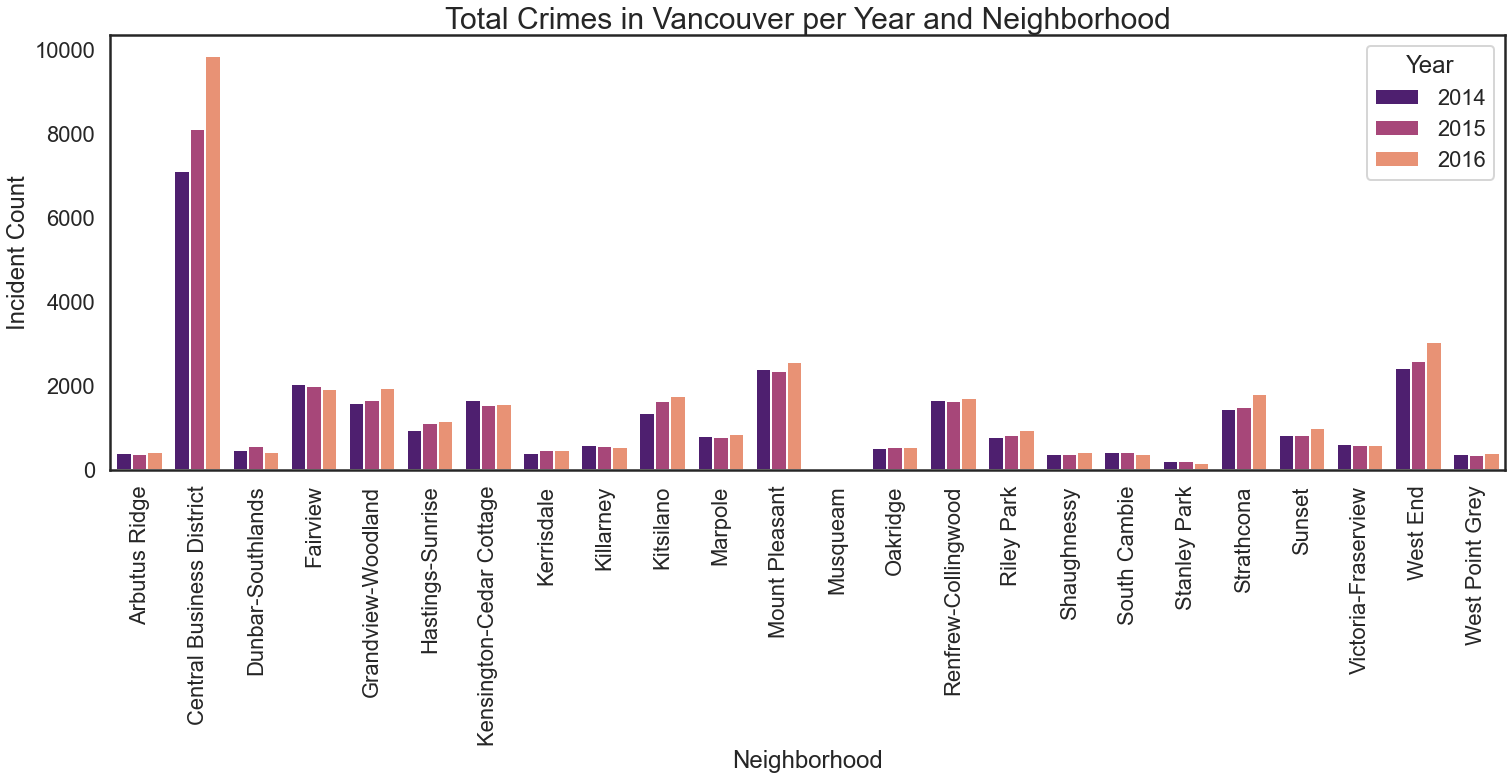

In [16]:
# Setting figure size:
sns.set_style('white')
sns.set_context('poster')
plt.figure(figsize=(25,8))
# Creating bar plot:
sns.barplot(data=crime_per_hood, x='Neighborhood', y='Type', hue='Year', palette='magma')
plt.xticks(rotation=90)
plt.ylabel('Incident Count')
plt.title('Total Crimes in Vancouver per Year and Neighborhood', fontsize=30)
# Saving figure:
plt.savefig('crime_per_hood.png', dpi=200, bbox_inches='tight')
plt.show()

**Observation:** across all 3 years, the total number of crimes per neighborhood appears to be quite consistent (only the Central Business District shows increase in crimes every year). Now, we would look at crimes per type.

In [17]:
# Comparing evolution of crime per type for all 3 years:
crime_per_type = vancouver_crime.groupby(['Type', 'Year']).Neighborhood.count().reset_index()
crime_per_type.head()

,Type,Year,Neighborhood
0,Break and Enter Commercial,2014,2244
1,Break and Enter Commercial,2015,2457
2,Break and Enter Commercial,2016,2686
3,Break and Enter Residential,2014,3044
4,Break and Enter Residential,2015,3121


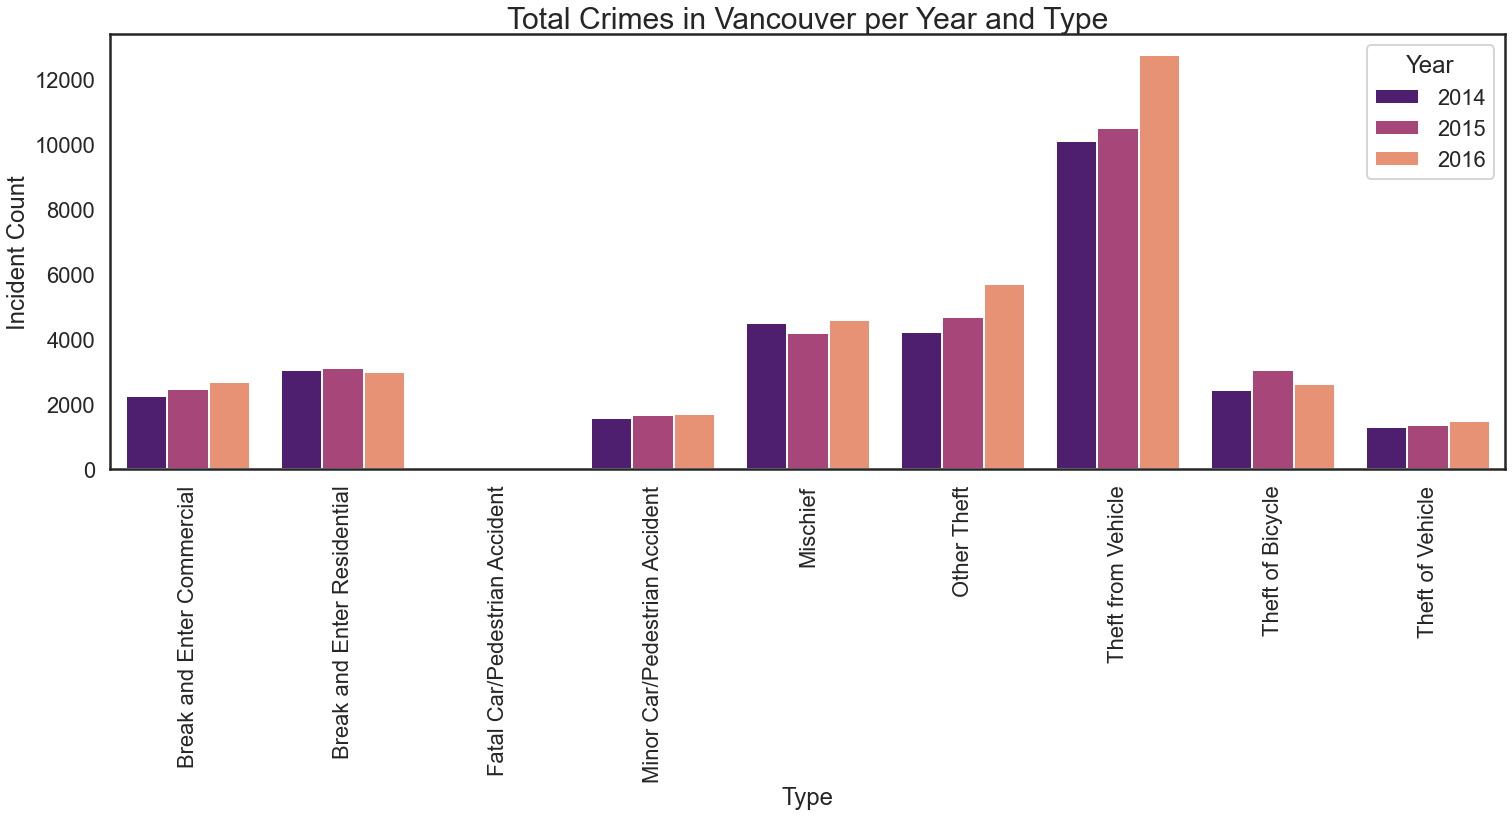

In [18]:
# Setting figure size:
sns.set_style('white')
sns.set_context('poster')
plt.figure(figsize=(25, 8))
# Creating bar plot:
sns.barplot(data=crime_per_type, x='Type', y='Neighborhood', hue='Year', palette='magma')
plt.xticks(rotation=90)
plt.ylabel('Incident Count')
plt.title('Total Crimes in Vancouver per Year and Type', fontsize=30)
# Saving figure:
plt.savefig('crime_per_type.png', dpi=200, bbox_inches='tight')
plt.show()

**Observation:** across all 3 years, the total number of crimes per type appears to be quite consistent, with a slight increase per year with the exception of 'Theft from Vehicle', which shows a bigger increase in 2016. Finally, we will look at crimes per month.

In [20]:
# Comparing evolution of crime per month for all 3 years:
crime_per_month = vancouver_crime.groupby(['Month', 'Year']).Neighborhood.count().reset_index()
crime_per_month.head()

,Month,Year,Neighborhood
0,1,2014,2174
1,1,2015,2397
2,1,2016,3075
3,2,2014,1897
4,2,2015,2109


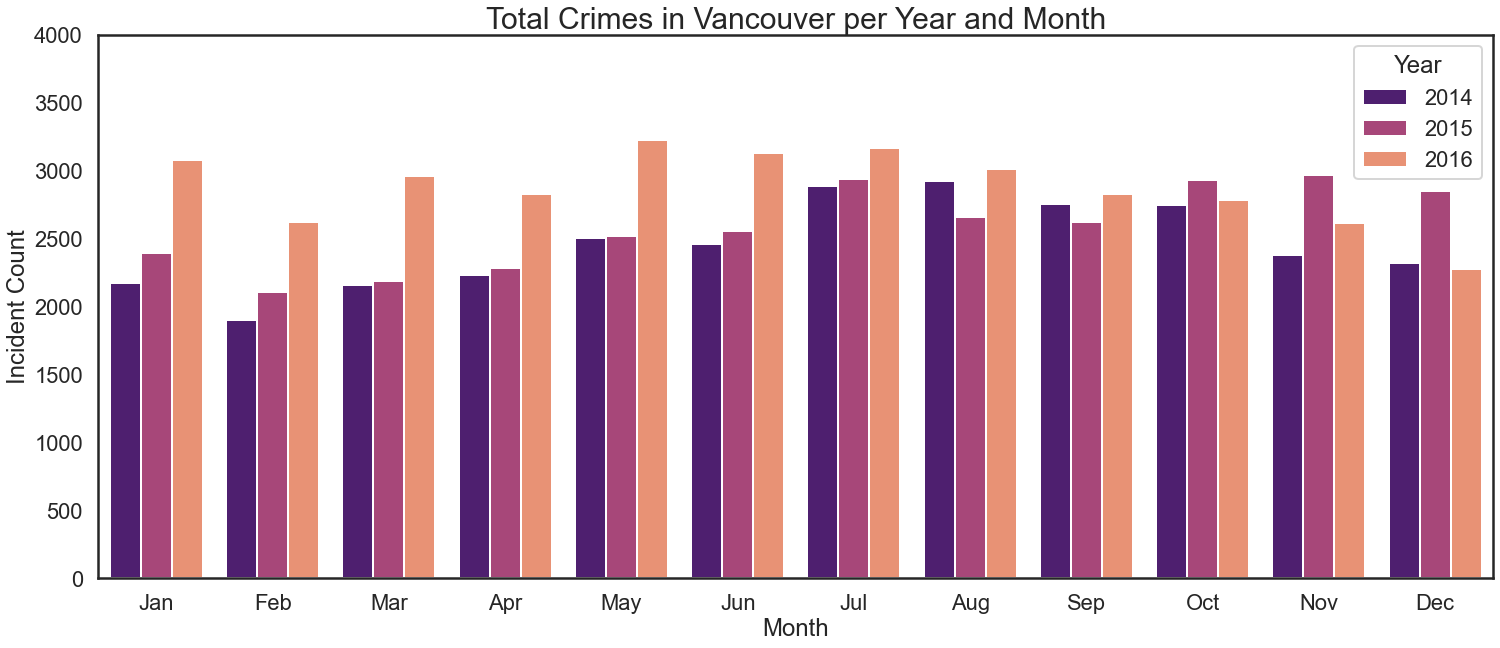

In [21]:
# Setting figure size:
sns.set_style('white')
sns.set_context("poster")
plt.figure(figsize=(25, 10))
# Creating bar plot:
ax = sns.barplot(data=crime_per_month, x='Month', y='Neighborhood', hue='Year', palette='magma')
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Incident Count')
ax.set_title('Total Crimes in Vancouver per Year and Month', fontsize=30)
ax.set_ylim(0,4000)
# Saving figure:
plt.savefig('crime_per_month.png', dpi=200, bbox_inches='tight')
plt.show()

**Observation:** in this case, the number of crimes per month increases noticeably from January till July during 2016 compared to the previous 2 years, then it remains consistent during the next 3 months for all 3 years. For November and December, there is a crime peak during 2015.

From this dataset, it can be concluded that overall criminal incident levels remained stable overall the 3 years, showing a small increase of 5% from 2014 to 2015, and of 11% from 2015 to 2016. Since this project focuses on classifying neighborhoods amongst them by number of incidents to find the safer ones, and we have found that across years the number of incidents per neighborhood remains stable, we could average the number of crimes per type and neighborhood to have a simpler database to use, which will be done in the analysis section.

### Coordenates Data

Using the Geolocator package, we can look for the coordenates (latitude and longitude) for each neighborhood taken from the crime dataset. Then, the coordenates can be plotted on a map of Vancouver to check if all the neighborhoods have been accurately located.

First, a list of all neighborhoods needs to be created to use the Geolocator package on them.

In [22]:
# Defining list of neighborhoods:
neighborhoods = list(vancouver_crime.Neighborhood.unique())
print('Number of neighborhoods: ', len(neighborhoods), '\n')
print('List of neighborhoods: ', neighborhoods)

Number of neighborhoods:  24 

List of neighborhoods:  ['Hastings-Sunrise', 'Victoria-Fraserview', 'Central Business District', 'Dunbar-Southlands', 'Killarney', 'Oakridge', 'Kitsilano', 'West End', 'Kensington-Cedar Cottage', 'Kerrisdale', 'Grandview-Woodland', 'Sunset', 'Mount Pleasant', 'Renfrew-Collingwood', 'Riley Park', 'Shaughnessy', 'Marpole', 'Strathcona', 'Fairview', 'Stanley Park', 'South Cambie', 'Arbutus Ridge', 'West Point Grey', 'Musqueam']


In [23]:
# Using Geolocation package in a for loop to find the coordenates of all neighborhoods from the list:
coordenates = []
for hood in neighborhoods:
    address = hood + ', Vancouver, British Columbia'
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    lat = location.latitude
    long = location.longitude
    item = [hood, lat, long]
    coordenates.append(item)
print(coordenates[:5])

[['Hastings-Sunrise', 49.27871395, -123.03999830466525], ['Victoria-Fraserview', 49.2189795, -123.06381586330446], ['Central Business District', 49.33612, -123.0780208], ['Dunbar-Southlands', 49.23786405, -123.18435438641457], ['Killarney', 49.21801175, -123.03711501300283]]


In [24]:
# Organizing coordenates information into a dataframe:
coordenates.sort()
locations = pd.DataFrame(coordenates)
locations.columns = ['Neighborhood', 'Latitude', 'Longitude']
locations.head()

,Neighborhood,Latitude,Longitude
0,Arbutus Ridge,49.246305,-123.159636
1,Central Business District,49.336120,-123.078021
2,Dunbar-Southlands,49.237864,-123.184354
3,Fairview,49.261956,-123.130408
4,Grandview-Woodland,49.275849,-123.066934


Before plotting the map of Vancouver, it is required to find its coordenates (city as a whole) to center the visualization:

In [25]:
# Obtaining the Toronto Coordenates to center the visualization:
address = 'Vancouver, British Columbia'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
vancouver_lat = location.latitude
vancouver_long = location.longitude
print('The geograpical coordinates of Vancouver are {}, {}.'.format(vancouver_lat, vancouver_long))

The geograpical coordinates of Vancouver are 49.2608724, -123.1139529.


Now, plotting the location of each neighborhood in Vancouver:

In [26]:
# Creating map of Vancouver with coordenates from locations list:
vancouver_map = folium.Map(location=[vancouver_lat, vancouver_long], zoom_start=11)
# Adding markers to map:
for lat, lng, neighborhood in zip(locations['Latitude'], locations['Longitude'], locations['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],radius=6,popup=label,color='blue',fill=True,fill_color='blue',fill_opacity=0.4,
        parse_html=False).add_to(vancouver_map)  
# Saving figure:
vancouver_map.save('vancouver_map_geo.html')   
vancouver_map

Comparing with a Vancouver city map from Google Maps (manual inspection), it can quickly be seen that for some neighborhoods the coordenates found via the Geolocator Package have not been accurate. Examples are Musqueam and Central Business District (which does not even show in Vancouver, but far north, which should not be the case). Therefore, a different approach for mapping the real locations of the neighborhood will be used via the Crime Dataset.

We will use the average of all the latitude and longitude data for all the crimes in the dataset grouped by neighbourhood, and plot this information in the map to see if a better geographical representation of each neighbouhood can be found with this method.

In [27]:
# Defining grouped dataset for coordenates by neighborhood:
crime_latitudes = vancouver_crime.groupby('Neighborhood').Latitude.mean()
crime_longitudes = vancouver_crime.groupby('Neighborhood').Longitude.mean()
crime_locs = pd.merge(crime_latitudes,crime_longitudes,left_on='Neighborhood',right_on='Neighborhood').reset_index()
crime_locs

,Neighborhood,Latitude,Longitude
0,Arbutus Ridge,49.245787,-123.160772
1,Central Business District,49.281248,-123.114846
2,Dunbar-Southlands,49.245016,-123.185095
3,Fairview,49.264283,-123.128927
4,Grandview-Woodland,49.275277,-123.067623
5,Hastings-Sunrise,49.276450,-123.042535
6,Kensington-Cedar Cottage,49.248876,-123.072525
7,Kerrisdale,49.227909,-123.158447
8,Killarney,49.220965,-123.036435
9,Kitsilano,49.266763,-123.160811


In [28]:
# Creating map of Vancouver with new coordenates from crime_locs list:
vancouver_map = folium.Map(location=[vancouver_lat, vancouver_long], zoom_start=12)
# Adding markers to map:
for lat, lng, neighborhood in zip(crime_locs['Latitude'], crime_locs['Longitude'], crime_locs['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],radius=8,popup=label,color='black',fill=True,fill_color='black',fill_opacity=0.4,
        parse_html=False).add_to(vancouver_map)
# Saving figure:
vancouver_map.save('vancouver_map_loc.html')   
vancouver_map

This time, all neighborhoods are correctly mapped in the visualization, as it can be manually checked for each one (refer for instance to Musqueam o Central Business District compared to the previous visualization). Therefore, the `crime_locs` dataframe will be the official coordenates reference for the rest of the project.

### Commercial Venues per Neighborhood Data

In [22]:
# Using Foursquare API for obtaining venues location:
# Defining the Foursquare credentials:
CLIENT_ID = 'S1IC2GEN1LHJWHQ0YD44BW344JDVCL0UBHVJXDCJ4DCIRQHJ' # your Foursquare ID
CLIENT_SECRET = 'ARS0DCNZVEH4EYDYTZNWHNN0TJ4EPK2GTVKH1L2JNO31ULVW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
print('Credentails Data:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails Data:
CLIENT_ID: S1IC2GEN1LHJWHQ0YD44BW344JDVCL0UBHVJXDCJ4DCIRQHJ
CLIENT_SECRET:ARS0DCNZVEH4EYDYTZNWHNN0TJ4EPK2GTVKH1L2JNO31ULVW


In [23]:
# Defining function for obtaining the data per venue for each neighborhood and arranging it into a dataset:
def getNearbyVenues(names, latitudes, longitudes, radius=1000): # Radius defined as 2 km cover the average distance between each neighborhood aprox.
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [24]:
# Using the created function on the crime_locs dataframe:
vancouver_venues = getNearbyVenues(names=crime_locs['Neighborhood'],
                                   latitudes=crime_locs['Latitude'],
                                   longitudes=crime_locs['Longitude'])

Arbutus Ridge
Central Business District
Dunbar-Southlands
Fairview
Grandview-Woodland
Hastings-Sunrise
Kensington-Cedar Cottage
Kerrisdale
Killarney
Kitsilano
Marpole
Mount Pleasant
Musqueam
Oakridge
Renfrew-Collingwood
Riley Park
Shaughnessy
South Cambie
Stanley Park
Strathcona
Sunset
Victoria-Fraserview
West End
West Point Grey


In [25]:
# Exploring the obtained dataframe:
print('The shape of the venues dataset is: ',vancouver_venues.shape,'\n')
vancouver_venues.head()

The shape of the venues dataset is:  (1334, 7) 



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,49.245787,-123.160772,The Patty Shop,49.250680,-123.167916,Caribbean Restaurant
1,Arbutus Ridge,49.245787,-123.160772,Butter Baked Goods,49.242209,-123.170381,Bakery
2,Arbutus Ridge,49.245787,-123.160772,The Arbutus Club,49.248507,-123.152152,Event Space
3,Arbutus Ridge,49.245787,-123.160772,Quilchena Park,49.245194,-123.151211,Park
4,Arbutus Ridge,49.245787,-123.160772,La Buca,49.250549,-123.167933,Italian Restaurant


As seem above, the Foursquare data has provided the project the venue names, categories and locations for each venue within each neighborhood (1 observation or row represents 1 venue). Now that all the project data is available, we will explore the `vancouver_venues` dataframe before defining the methodology of the analysis that will follow.

In [26]:
print('Number of venues found per neighborhood:')
count_of_venues = pd.DataFrame(vancouver_venues.value_counts('Neighborhood')).reset_index()
count_of_venues.rename(columns={0:'Count'},inplace=True)
count_of_venues.sort_values(by='Count', ascending=True, inplace=True)
count_of_venues

Number of venues found per neighborhood:


,Neighborhood,Count
23,Musqueam,5
22,Shaughnessy,14
21,Dunbar-Southlands,18
20,Arbutus Ridge,20
19,Renfrew-Collingwood,21
18,Killarney,21
17,Victoria-Fraserview,22
16,West Point Grey,28
15,Stanley Park,30
14,Kerrisdale,41


In [27]:
print('Number of unique venue categories found in dataframe: ', vancouver_venues['Venue Category'].nunique(),'\n')
print('Number of venues found per venue category (top 20):')
vancouver_venues.value_counts('Venue Category').iloc[:20]

Number of unique venue categories found in dataframe:  220 

Number of venues found per venue category (top 20):


Venue Category
Coffee Shop              81
Park                     56
Café                     46
Sushi Restaurant         41
Vietnamese Restaurant    40
Bakery                   38
Chinese Restaurant       37
Japanese Restaurant      35
Pizza Place              26
Restaurant               26
Sandwich Place           25
Indian Restaurant        23
Bus Stop                 23
Grocery Store            22
Bank                     22
Brewery                  21
Hotel                    19
Dessert Shop             18
Breakfast Spot           18
Seafood Restaurant       18
dtype: int64

## Methodology <a name='methodology_'></a>

TBD

## Analysis <a name='analysis_'></a>

### Exploratory Data Analysis and Arrangement of Crime Data

In [28]:
# Re-arranging crime data per neighborhood, type and year:
crime_per_hood_type = vancouver_crime.groupby(['Neighborhood','Type','Year']).Month.count().reset_index()
crime_per_hood_type.rename(columns={'Month':'Crime Count', 'Type':'Type of Crime'}, inplace=True)
print('Total number of crimes in dataset (all 3 years): ', crime_per_hood_type['Crime Count'].sum(),'\n')
crime_per_hood_type.head()

Total number of crimes in dataset (all 3 years):  94965 



,Neighborhood,Type of Crime,Year,Crime Count
0,Arbutus Ridge,Break and Enter Commercial,2014,28
1,Arbutus Ridge,Break and Enter Commercial,2015,13
2,Arbutus Ridge,Break and Enter Commercial,2016,32
3,Arbutus Ridge,Break and Enter Residential,2014,129
4,Arbutus Ridge,Break and Enter Residential,2015,103


In [29]:
# Creating pivot table (columns per type of crime):
crime_pivot = crime_per_hood_type.pivot(columns='Type of Crime',index=['Neighborhood','Year'],values='Crime Count').reset_index()
crime_pivot.fillna(value=0, inplace=True)
crime_pivot.head()

Type of Crime,Neighborhood,Year,Break and Enter Commercial,Break and Enter Residential,Fatal Car/Pedestrian Accident,Minor Car/Pedestrian Accident,Mischief,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle
0,Arbutus Ridge,2014,28.0,129.0,0.0,28.0,35.0,16.0,140.0,17.0,14.0
1,Arbutus Ridge,2015,13.0,103.0,0.0,20.0,40.0,26.0,128.0,19.0,15.0
2,Arbutus Ridge,2016,32.0,84.0,0.0,27.0,48.0,53.0,155.0,22.0,10.0
3,Central Business District,2014,570.0,188.0,3.0,210.0,1285.0,1479.0,2624.0,664.0,94.0
4,Central Business District,2015,802.0,138.0,1.0,241.0,1225.0,1643.0,2969.0,947.0,132.0


It would be interesting to see if there is a relationship between the different types of crime occurance. A heatmap would help in visualizing the correlation between each type of crime:

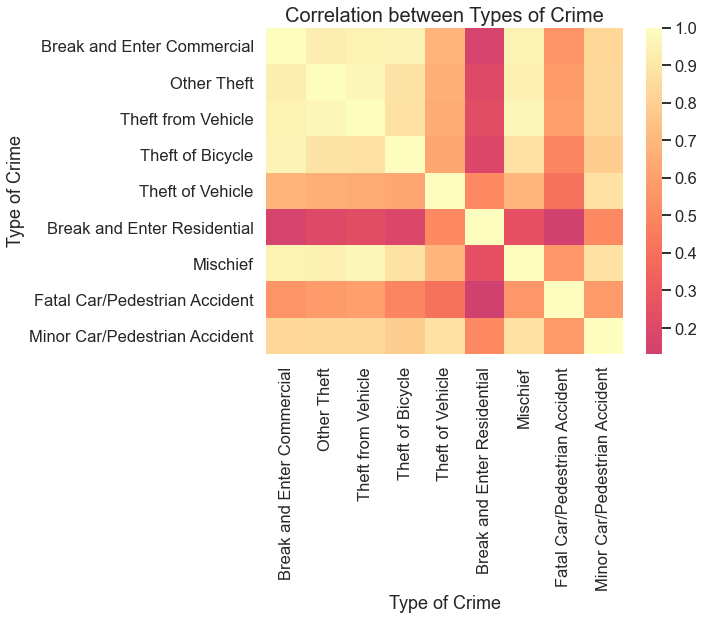

In [30]:
# Setting columns to evaluate:
col_to_eval = ['Break and Enter Commercial','Other Theft','Theft from Vehicle','Theft of Bicycle','Theft of Vehicle',
              'Break and Enter Residential', 'Mischief', 
                          'Fatal Car/Pedestrian Accident',
                         'Minor Car/Pedestrian Accident']
# Setting figure size:
plt.figure(figsize=(8, 6))
sns.set_context('talk')
# Creating heatmap:
sns.heatmap(crime_pivot[col_to_eval].corr(), cmap='magma', center=0, robust=True)
plt.title('Correlation between Types of Crime', fontsize=20)
# Saving figure:
plt.savefig('heatmap.png', dpi=200, bbox_inches='tight')  
plt.show()

Since the purpose of the project is to find the safest location for a commercial location (Argus' office), not all types of crimes are relevant. Some crimes like 'Fatal Car/Pedestrian Accident' and 'Minor Car/Pedestrian Accident' can be disregarded from the analysis.

Clearly the most representative type of crime for the project purpose is 'Break and Enter Commercial'. Therefore, we will explore the relationship between this type of crime and the others, with the objective of selecting 2 features: one with a very high correlation with 'Break and Enter Commercial', and another with a less higher correlation with 'Break and Enter Commercial', since we would like to capture in our analysis another type of crime that is still relevant to the project.

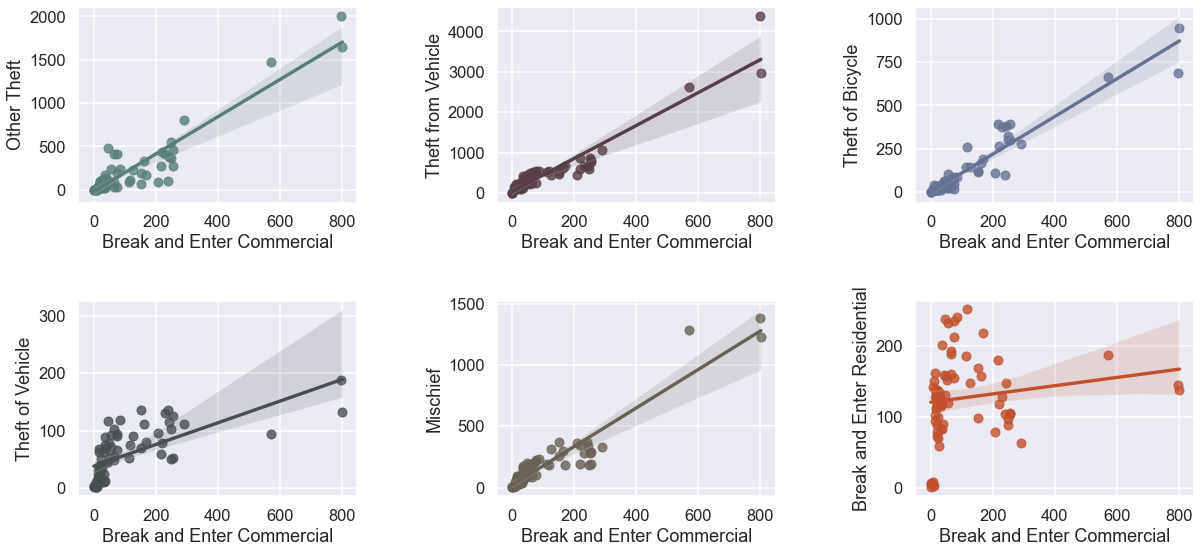

In [31]:
# Setting colors for each regression and columns to evaluate against 'Break and Enter Commercial':
colors = ['#587e76','#563f46','#667292','#484f4f','#686256','#c1502e']
features = ['Other Theft','Theft from Vehicle','Theft of Bicycle',
            'Theft of Vehicle','Mischief','Break and Enter Residential']
sns.set_style('darkgrid')
# Setting figure size:
plt.figure(figsize=(20, 9))
sns.set_context('talk')
# Creating regression plot:
for i in range(len(features)):
    axi = plt.subplot(2,3,i+1)
    sns.regplot(data=crime_pivot, x='Break and Enter Commercial', y=features[i], color=colors[i])
    axi.set_xlim(-50,850)
plt.subplots_adjust(wspace=0.5,hspace=0.5)
# Saving figure:
plt.savefig('regplots.png', dpi=200, bbox_inches='tight')  
plt.show()

The 3 selected types of crime will be 'Break and Enter Commercial', as explained above; 'Theft from Vehicle', which shows the highest correlation with the first type of crime both in the heatmap and in the regression plot; and 'Theft of Vehicle', which is type of crime that does not show a very high correlation with 'Break and Enter Commercial' (around 0.6) but is a relevant type of crime for the project (the amount of vehicle thefts speaks about how dangerous a neighborhood is).

Regarding 'Theft of Bicycle', although highly correlated with 'Break and Enter Commercial', it will be disregarded since it is not very relevant for the project (the fact that many bicycles are stolen in a particular neighborhood does not mean that the neighborhood itself will be dangerous for Argus' business). Same goes for 'Other Theft'. Regarding 'Break and Enter Residential', it shows a very low correlation with 'Break and Enter Commercial', which makes sense since most likely there are not many houses to break into in commercial neighborhoods and vice-versa, and therefore it is difficult to assess if a neighborhood with more or less crimes of this type might represent any danger to Argus or its customers.

Therefore, only 'Break and Enter Commercial', 'Theft from Vehicle', and 'Theft of Vehicle' will be included in the rest of the analysis. Now, we will create a master dataframe with 1 observation per neighborhood showing the total amount of crimes per type (average of all 3 years).

In [32]:
# Re-arranging crime data combining all years with averages:
crime_per_hood_type = crime_per_hood_type.groupby(['Neighborhood','Type of Crime'])['Crime Count'].mean().reset_index()
crime_per_hood_type['Crime Count'] = round(crime_per_hood_type['Crime Count'])
crime_per_hood_type.rename(columns={'Crime Count':'Avg Crime Count/Year'}, inplace=True)
print('Total number of crimes in dataset (average of 3 years): ', crime_per_hood_type['Avg Crime Count/Year'].sum(),'\n')
crime_per_hood_type.head()

Total number of crimes in dataset (average of 3 years):  31664.0 



,Neighborhood,Type of Crime,Avg Crime Count/Year
0,Arbutus Ridge,Break and Enter Commercial,24.0
1,Arbutus Ridge,Break and Enter Residential,105.0
2,Arbutus Ridge,Minor Car/Pedestrian Accident,25.0
3,Arbutus Ridge,Mischief,41.0
4,Arbutus Ridge,Other Theft,32.0


In [93]:
# Creating master pivot table of crimes:
master_pivot = crime_per_hood_type.pivot(columns='Type of Crime',index='Neighborhood',values='Avg Crime Count/Year').reset_index()
master_pivot.fillna(value=0, inplace=True)
master_pivot.drop(columns=['Break and Enter Residential', 'Mischief', 'Other Theft', 'Theft of Bicycle',
                          'Fatal Car/Pedestrian Accident',
                         'Minor Car/Pedestrian Accident'], inplace=True)
master_pivot.head()

Type of Crime,Neighborhood,Break and Enter Commercial,Theft from Vehicle,Theft of Vehicle
0,Arbutus Ridge,24.0,141.0,13.0
1,Central Business District,723.0,3325.0,138.0
2,Dunbar-Southlands,14.0,192.0,22.0
3,Fairview,240.0,656.0,54.0
4,Grandview-Woodland,146.0,527.0,113.0


It would be useful to have a measurement of the distribution of each type of crime. We can visualize it with the help of histograms.

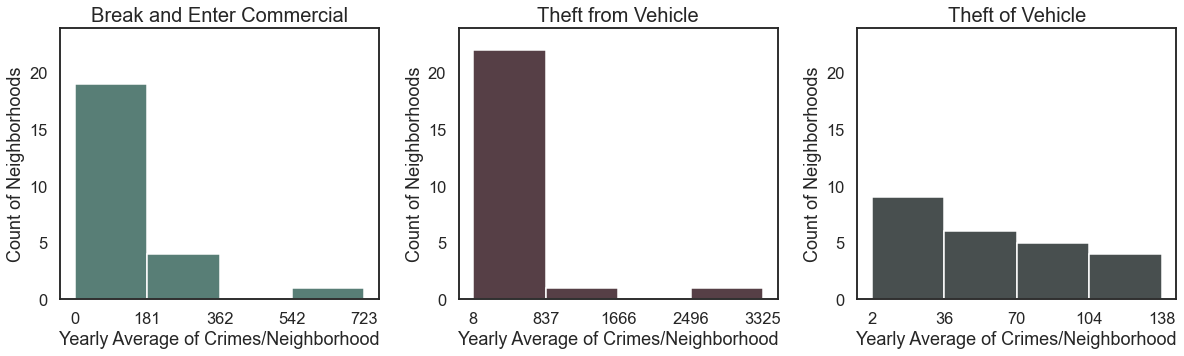

In [34]:
# Setting colors for each histogram and columns to evaluate:
colors = ['#587e76','#563f46','#484f4f']
features = ['Break and Enter Commercial','Theft from Vehicle','Theft of Vehicle']
sns.set_style('white')
# Setting figure size:
plt.figure(figsize=(20, 5))
sns.set_context('talk')
# Creating histogram plot:
tot_bins = []
for i in range(len(features)):
    axi = plt.subplot(1,3,i+1)
    n, bins, patches = plt.hist(master_pivot[features[i]], color=colors[i],bins=4)
    plt.ylabel('Count of Neighborhoods')
    plt.xlabel('Yearly Average of Crimes/Neighborhood')
    binx = [round(bin) for bin in bins]
    tot_bins.append(binx)
    plt.xticks(binx)
    plt.title(features[i],fontsize=20)
    plt.ylim(0,24)
# Saving figure:
plt.savefig('histograms.png', dpi=200, bbox_inches='tight') 
plt.subplots_adjust(wspace=0.25)

We could add a column in our master dataframe categorizing each neighborhood as 'Low Level Threat', 'Mid-Low Level Threat', 'Mid-High Level Threat', 'High Level Threat' according to the 4 bins in each histogram.

In [94]:
# Defining categories:
cat = ['Low', 'Mid-Low', 'Mid-High', 'High']
# Categorizing each feature:
for i in range(len(features)):
    master_pivot[features[i] + ' Threat'] = master_pivot.apply(lambda row: cat[0] if row[features[i]] < tot_bins[i][1] else
                                                           (cat[1] if row[features[i]] <= tot_bins[i][2] else
                                                           (cat[2] if row[features[i]] <= tot_bins[i][3] else
                                                           cat[3])),axis=1)
master_pivot.head()

Type of Crime,Neighborhood,Break and Enter Commercial,Theft from Vehicle,Theft of Vehicle,Break and Enter Commercial Threat,Theft from Vehicle Threat,Theft of Vehicle Threat
0,Arbutus Ridge,24.0,141.0,13.0,Low,Low,Low
1,Central Business District,723.0,3325.0,138.0,High,High,High
2,Dunbar-Southlands,14.0,192.0,22.0,Low,Low,Low
3,Fairview,240.0,656.0,54.0,Mid-Low,Low,Mid-Low
4,Grandview-Woodland,146.0,527.0,113.0,Low,Low,High


Finally, we can plot the map of Vancouver presenting the different neighborhods with tags detailing their names, number of crimes of each type; and assigning each marker a different color depending whether a neighborhood is considered safe (green), relatively safe with caution (orange) or dangerous (red) for being considered to host the new Argus office. The coloring criteria has been the following:
* Green or safe (if all 3 types of crime have the 'Low' category in the neighborhood)
* Red or dangerous (if at least 1 type of crime has the 'High' category)
* Orange or relatively safe with caution (everything in between)

In [36]:
# Defining lambda function for crime level:
threat = lambda row: 'Green' if (row['Break and Enter Commercial Threat']=='Low' and row['Theft from Vehicle Threat']=='Low'
                                 and row['Theft of Vehicle Threat']=='Low') else ('Red' if (
    row['Break and Enter Commercial Threat']=='High' or row['Theft from Vehicle Threat']=='High'
                                 or row['Theft of Vehicle Threat']=='High') else 'Orange')

In [95]:
# Adding Latitude and Longitude Values to the Master Pivot Table, and dropping unneded columns:
master_pivot = pd.merge(crime_locs,master_pivot,left_on='Neighborhood',right_on='Neighborhood')
master_pivot.drop(columns=['Break and Enter Commercial','Theft from Vehicle','Theft of Vehicle'],inplace=True)
# Applying lambda function:
master_pivot['Crime Threat Level'] = master_pivot.apply(threat, axis=1)
master_pivot

,Neighborhood,Latitude,Longitude,Break and Enter Commercial Threat,Theft from Vehicle Threat,Theft of Vehicle Threat,Crime Threat Level
0,Arbutus Ridge,49.245787,-123.160772,Low,Low,Low,Green
1,Central Business District,49.281248,-123.114846,High,High,High,Red
2,Dunbar-Southlands,49.245016,-123.185095,Low,Low,Low,Green
3,Fairview,49.264283,-123.128927,Mid-Low,Low,Mid-Low,Orange
4,Grandview-Woodland,49.275277,-123.067623,Low,Low,High,Red
5,Hastings-Sunrise,49.276450,-123.042535,Low,Low,Mid-High,Orange
6,Kensington-Cedar Cottage,49.248876,-123.072525,Low,Low,Mid-High,Orange
7,Kerrisdale,49.227909,-123.158447,Low,Low,Low,Green
8,Killarney,49.220965,-123.036435,Low,Low,Mid-Low,Orange
9,Kitsilano,49.266763,-123.160811,Low,Low,Mid-Low,Orange


In [41]:
# Creating map of Vancouver according to danger level:
vancouver_danger_map = folium.Map(location=[vancouver_lat, vancouver_long], zoom_start=12)
# Adding markers to map:
for lat, lng, hood, crime_level, threat1, threat2, threat3 in zip(master_pivot['Latitude'],master_pivot['Longitude'], 
                                                     master_pivot['Neighborhood'],master_pivot['Crime Threat Level'],
                                                                  master_pivot['Break and Enter Commercial Threat'],
                                                    master_pivot['Theft from Vehicle Threat'],master_pivot['Theft of Vehicle Threat']):
    label = '{} | Level of Threat: Break and Enter Commercial --> {}, Theft from Vehicle --> {}, Theft of Vehicle --> {}'.format(hood, threat1, threat2, threat3)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],radius=8,popup=label,color=crime_level,fill=True,fill_color=crime_level,
                            fill_opacity=0.5,parse_html=False).add_to(vancouver_danger_map)
# Saving figure:
vancouver_danger_map.save('vancouver_danger_map.html')   
vancouver_danger_map

### Exploratory Data Analysis and Arrangement of Venues Data

First, we would visually explore the number of venues found per neighborhood.

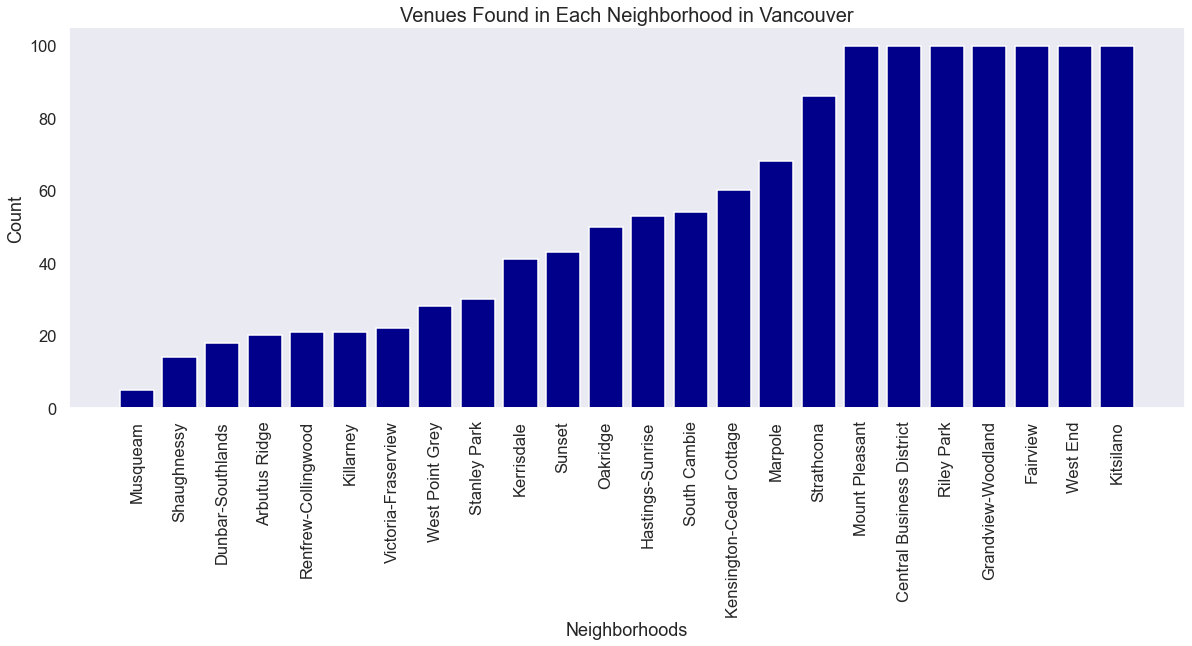

In [42]:
# Exploring number of venues found with in Vancouver:
sns.set_style('dark')
# Setting figure size:
plt.figure(figsize=(20, 7))
sns.set_context('talk')
# Creating regression plot:
plt.bar(range(len(count_of_venues)), count_of_venues.Count, color='darkblue')
plt.xlabel('Neighborhoods')
plt.ylabel('Count')
plt.title('Venues Found in Each Neighborhood in Vancouver', fontsize=20)
plt.xticks(ticks=range(len(count_of_venues)), labels=count_of_venues.Neighborhood, rotation=90)
# Saving figure:
plt.savefig('count_of_venues.png', dpi=200, bbox_inches='tight')
plt.show()

Next step is to perform one-hot encoding to create new columns with a binary choice (0 or 1) for each type of venue for each neighborhood.

In [43]:
# One hot encoding:
vancouver_onehot = pd.get_dummies(vancouver_venues[['Venue Category']], prefix="", prefix_sep="")
# Add neighborhood column back to dataframe:
vancouver_onehot['Neighborhood'] = vancouver_venues.Neighborhood 
# Moving neighborhood column to the first column
fixed_columns = [vancouver_onehot.columns[-1]] + list(vancouver_onehot.columns[:-1])
vancouver_onehot = vancouver_onehot[fixed_columns]
print(vancouver_onehot.shape)
vancouver_onehot.head()

(1334, 221)


,Neighborhood,Accessories Store,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Trade School,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Shop,Women's Store,Yoga Studio
0,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, the one-hot dataframe will be grouped per neighborhood (using the mean of each type of venue) to find the frequency of each type of venue per neighborhood.

In [44]:
# Grouping by neighborhood and calculating means:
vancouver_freq = vancouver_onehot.groupby('Neighborhood').mean().reset_index()
vancouver_freq.head()

,Neighborhood,Accessories Store,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Trade School,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Shop,Women's Store,Yoga Studio
0,Arbutus Ridge,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,Central Business District,0.00,0.02,0.0,0.0,0.01,0.00,0.00,0.00,0.0,...,0.01,0.0,0.02,0.0,0.01,0.00,0.00,0.00,0.00,0.00
2,Dunbar-Southlands,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3,Fairview,0.01,0.02,0.0,0.0,0.00,0.03,0.01,0.00,0.0,...,0.00,0.0,0.01,0.0,0.01,0.01,0.01,0.00,0.01,0.02
4,Grandview-Woodland,0.00,0.00,0.0,0.0,0.00,0.00,0.01,0.01,0.0,...,0.00,0.0,0.02,0.0,0.02,0.00,0.00,0.01,0.00,0.00


A new dataframe will be created for displaying the most common venues (top 5) for each neighborhood in different columns.

In [45]:
# Defining a function for sortering the venues in descending order:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
# Creating the dataframe:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
# Create columns according to number of top venues:
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# Creating the new dataframe:
top_venues = pd.DataFrame(columns=columns)
top_venues['Neighborhood'] = vancouver_freq['Neighborhood']

for ind in np.arange(vancouver_freq.shape[0]):
    top_venues.iloc[ind, 1:] = return_most_common_venues(vancouver_freq.iloc[ind, :], num_top_venues)
print('The shape of the venues dataset is:',top_venues.shape,'\n')
top_venues.head()

The shape of the venues dataset is: (24, 6) 



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arbutus Ridge,Bakery,Burger Joint,Event Space,Bubble Tea Shop,Caribbean Restaurant
1,Central Business District,Hotel,Coffee Shop,Restaurant,Dessert Shop,Taco Place
2,Dunbar-Southlands,Pharmacy,Bakery,Bank,Cosmetics Shop,Baseball Field
3,Fairview,Coffee Shop,Park,Restaurant,Furniture / Home Store,Japanese Restaurant
4,Grandview-Woodland,Coffee Shop,Brewery,Pizza Place,Café,Sushi Restaurant


### Neighborhoods Classification with K-Means Clustering

Now, K-Means Clustering will be used for classifying the neighborhoods according to the frequency of the different venues in each of them. This Machine Learning tool was selected since it provides unsupervised learning (which is the case) and specializes in classification. Yet, before using it to determine to which category each neighborhood corresponds, we need to determine the optimal number of clusters or 'k' by exploring the inertia of the model.

In [47]:
# Defining range of number of clusters to explore:
num_clusters = list(range(1,11))
inertias = []
venues_data = vancouver_freq.drop('Neighborhood', axis=1)
# Fitting for inertia evaluation:
for k in num_clusters:
  model = KMeans(n_clusters=k, random_state=0).fit(venues_data)
  inertias.append(model.inertia_)
print('Success!')

Success!


Now, we can plot every inertia value against the number of groups 'k' required to find the 'k' that drives the elbow or drastic inertia reduction:

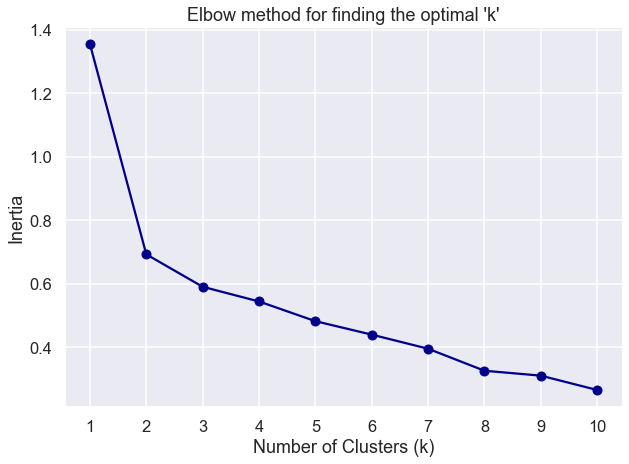

In [48]:
# Exploring inertia reduction with every 'k' value:
sns.set_style('darkgrid')
# Setting figure size:
plt.figure(figsize=(10, 7))
sns.set_context('talk')
plt.plot(num_clusters, inertias, '-o', color='darkblue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(num_clusters)
plt.title('Elbow method for finding the optimal \'k\'')
# Saving figure:
plt.savefig('inertias.png', dpi=200, bbox_inches='tight')
plt.show()

From the graph, there is a clear 'elbow' that can be identified for k=2, with another 'less severe' in k=3. This trend continues for the next k values, reducing inertia by ~0.1 with each k+1 increase. We will explore k values from k=2 till k=5:

**K-Means Clustering with k=2**

In [62]:
# Running k-means clustering:
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(venues_data)
# Checking cluster labels generated for each row in the dataframe:
k2_labels = pd.DataFrame(kmeans_2.labels_)
k2_labels_vc = k2_labels.value_counts()
print('Names of clusters and count of neighborhoods per cluster: ',)
k2_labels_vc

Names of clusters and count of neighborhoods per cluster: 


1    23
0     1
dtype: int64

**K-Means Clustering with k=3**

In [63]:
# Running k-means clustering:
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(venues_data)
# Checking cluster labels generated for each row in the dataframe:
k3_labels = pd.DataFrame(kmeans_3.labels_)
k3_labels_vc = k3_labels.value_counts()
print('Names of clusters and count of neighborhoods per cluster: ',)
k3_labels_vc

Names of clusters and count of neighborhoods per cluster: 


0    21
2     2
1     1
dtype: int64

**K-Means Clustering with k=4**

In [64]:
# Running k-means clustering:
kmeans_4 = KMeans(n_clusters=4, random_state=0).fit(venues_data)
# Checking cluster labels generated for each row in the dataframe:
k4_labels = pd.DataFrame(kmeans_4.labels_)
k4_labels_vc = k4_labels.value_counts()
print('Names of clusters and count of neighborhoods per cluster: ',)
k4_labels_vc

Names of clusters and count of neighborhoods per cluster: 


0    19
2     2
3     2
1     1
dtype: int64

**K-Means Clustering with k=5**

In [65]:
# Running k-means clustering:
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(venues_data)
# Checking cluster labels generated for each row in the dataframe:
k5_labels = pd.DataFrame(kmeans_5.labels_)
k5_labels_vc = k5_labels.value_counts()
print('Names of clusters and count of neighborhoods per cluster: ',)
k5_labels_vc

Names of clusters and count of neighborhoods per cluster: 


2    18
1     2
4     2
0     1
3     1
dtype: int64

**K-Means Clustering with k=6**

In [66]:
# Running k-means clustering:
kmeans_6 = KMeans(n_clusters=6, random_state=0).fit(venues_data)
# Checking cluster labels generated for each row in the dataframe:
k6_labels = pd.DataFrame(kmeans_6.labels_)
k6_labels_vc = k6_labels.value_counts()
print('Names of clusters and count of neighborhoods per cluster: ',)
k6_labels_vc

Names of clusters and count of neighborhoods per cluster: 


2    17
1     2
4     2
0     1
3     1
5     1
dtype: int64

After analysing the results of each K-Means with different k values (from k=2 to k=6), we can draw some conclusions:
* For k=2, we obtained 2 clusters, but in reality we only separated 1 neighborhood from the rest. Although the inercia was reduced considerably, having a cluster of 23 neighborhoods and another of only 1 is not very helpful
* For k=3, although inertia keeps reducing, we still have 21 neighborhoods in one cluster, with 2 and 1 neighborhoods respectively on the onther 2 clusters. Since we would like to have at least 2 clusters with 2 different types of venues to discriminate, we would keep exploring with higher k values
* For k=4, inertia keeps reducing, and we have 1 cluster with 19 neighborhoods, 2 clusters with 2 neighborhoods, and 1 cluster with 1 neighborhood, with seems more reasonable
* For k=5 and k=6. The inertia further reduces, but at a smaller rate, and creating more clusters with only 1 neighborhood, which is not optimal

Therefore, the selected k value will be **k=4**.

Now, we will add the labels to each cluster in our `master_pivot` table and name each cluster according to the types of venues that they group.

Creating a new dataframe that combines the cluster as well as the top 5 venues for each neighborhood.

In [96]:
# Adding clustering labels:
master_pivot.insert(7, 'Cluster Venue Label', kmeans_4.labels_)
# Merging the datasets:
master_pivot_labels = pd.merge(master_pivot, top_venues, left_on='Neighborhood', right_on='Neighborhood')
master_pivot_labels

,Neighborhood,Latitude,Longitude,Break and Enter Commercial Threat,Theft from Vehicle Threat,Theft of Vehicle Threat,Crime Threat Level,Cluster Venue Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arbutus Ridge,49.245787,-123.160772,Low,Low,Low,Green,0,Bakery,Burger Joint,Event Space,Bubble Tea Shop,Caribbean Restaurant
1,Central Business District,49.281248,-123.114846,High,High,High,Red,0,Hotel,Coffee Shop,Restaurant,Dessert Shop,Taco Place
2,Dunbar-Southlands,49.245016,-123.185095,Low,Low,Low,Green,2,Pharmacy,Bakery,Bank,Cosmetics Shop,Baseball Field
3,Fairview,49.264283,-123.128927,Mid-Low,Low,Mid-Low,Orange,0,Coffee Shop,Park,Restaurant,Furniture / Home Store,Japanese Restaurant
4,Grandview-Woodland,49.275277,-123.067623,Low,Low,High,Red,0,Coffee Shop,Brewery,Pizza Place,Café,Sushi Restaurant
5,Hastings-Sunrise,49.276450,-123.042535,Low,Low,Mid-High,Orange,0,Park,Vietnamese Restaurant,Theme Park Ride / Attraction,Event Space,Pharmacy
6,Kensington-Cedar Cottage,49.248876,-123.072525,Low,Low,Mid-High,Orange,0,Vietnamese Restaurant,Chinese Restaurant,Park,Bus Stop,Bank
7,Kerrisdale,49.227909,-123.158447,Low,Low,Low,Green,0,Coffee Shop,Chinese Restaurant,Bus Stop,Bank,Café
8,Killarney,49.220965,-123.036435,Low,Low,Mid-Low,Orange,0,Gas Station,Coffee Shop,Bakery,Farmers Market,Sandwich Place
9,Kitsilano,49.266763,-123.160811,Low,Low,Mid-Low,Orange,0,Coffee Shop,Yoga Studio,Sushi Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant


Plotting the neighborhood locations in a map combining danger level and number of cluster:
* Level of danger (circle borders, green, orange or red)
* Number of venue cluster (circle fill)

In [102]:
num_of_clusters = 4
# Setting color scheme for the clusters:
colors = ['lightblue','darkblue','pink','darkred','lightyellow', 'chocolate']
# Creating cluster map:
clusters_map = folium.Map(location=[vancouver_lat, vancouver_long], zoom_start=12)
# Add markers to the map
for lat, lon, hood, crime_level, cluster in zip(master_pivot['Latitude'], master_pivot['Longitude'], 
                                                master_pivot['Neighborhood'], master_pivot['Crime Threat Level'],
                                                master_pivot['Cluster Venue Label']):
    label = folium.Popup(str(hood) + ' | Level of Threat: ' + str(crime_level) + ' | Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=9,popup=label,color=crime_level,fill=True,
                        fill_color=colors[cluster],fill_opacity=1).add_to(clusters_map)
# Saving figure:
clusters_map.save('clusters_map.html')       
clusters_map

It will be useful to plot a bar chart showing the number of types of venue as '1st Most Common Venue' per cluster to give the cluster name. Therefore:

In [98]:
venues_1st_place = master_pivot_labels.groupby(['1st Most Common Venue','Cluster Venue Label']).Neighborhood.count().reset_index()
venues_1st_place

,1st Most Common Venue,Cluster Venue Label,Neighborhood
0,Bakery,0,1
1,Bank,0,1
2,Bus Stop,0,1
3,Café,0,1
4,Coffee Shop,0,7
5,Convenience Store,0,1
6,Garden,0,1
7,Gas Station,0,1
8,Golf Course,1,1
9,Hotel,0,2


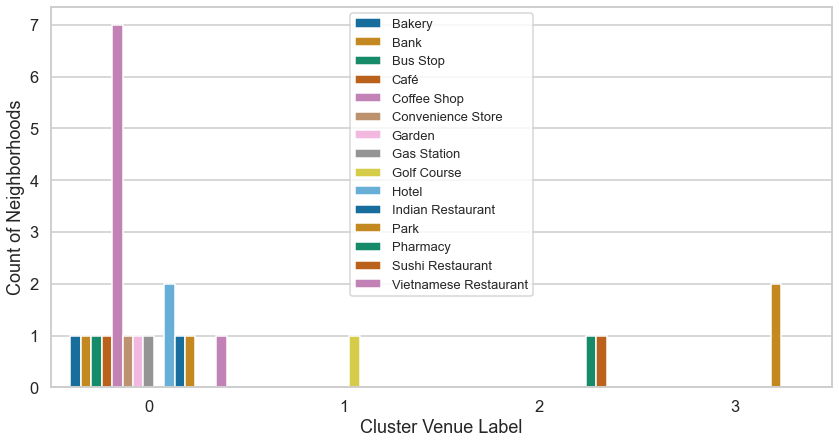

In [99]:
# Plotting number of venues per type for each cluster:
sns.set_style('whitegrid')
# Setting figure size:
plt.figure(figsize=(14, 7))
sns.set_context('talk')
sns.barplot(data=venues_1st_place,x='Cluster Venue Label',y='Neighborhood',hue='1st Most Common Venue',palette='colorblind')
plt.ylabel('Count of Neighborhoods')
plt.legend(fontsize=13,loc=9)
plt.show()

From the graph, 4 groups can be identified:
* Cluster 0: 'Coffee Shops and Other Commercial' (Bakeries, Banks, Cafés, Coffee Shops, Convenience Store, Gas Stations and Hotels)
* Cluster 1: 'Golf Courses'
* Cluster 2: 'Pharmacies and Restaurants'
* Cluster 3: 'Parks'

Finally, we can add the cluster labels to our `master_pivot_labels`.

In [104]:
# Changing cluster label names:
master_pivot_labels['Type of Venues in Cluster'] = master_pivot_labels['Cluster Venue Label'].map({
    0:'Coffee Shops and Other Commercial',1:'Golf Courses',2:'Pharmacies and Restaurants',3:'Parks'})
# Dropping unneded columns for final 
master_pivot_labels.drop(['Cluster Venue Label','4th Most Common Venue','5th Most Common Venue'],axis=1,inplace=True)
master_pivot_labels.head()

,Neighborhood,Latitude,Longitude,Break and Enter Commercial Threat,Theft from Vehicle Threat,Theft of Vehicle Threat,Crime Threat Level,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Type of Cluster Venue
0,Arbutus Ridge,49.245787,-123.160772,Low,Low,Low,Green,Bakery,Burger Joint,Event Space,Coffee Shops and Other Commercial
1,Central Business District,49.281248,-123.114846,High,High,High,Red,Hotel,Coffee Shop,Restaurant,Coffee Shops and Other Commercial
2,Dunbar-Southlands,49.245016,-123.185095,Low,Low,Low,Green,Pharmacy,Bakery,Bank,Pharmacies and Restaurants
3,Fairview,49.264283,-123.128927,Mid-Low,Low,Mid-Low,Orange,Coffee Shop,Park,Restaurant,Coffee Shops and Other Commercial
4,Grandview-Woodland,49.275277,-123.067623,Low,Low,High,Red,Coffee Shop,Brewery,Pizza Place,Coffee Shops and Other Commercial


## Results and Discussion <a name='results_'></a>

Before discussing the final results, it will be useful to visualize the final results in both table and map (Folium) format:

### Vancouver Neighborhoods Classified by Threat of Crime and Type of Venues in Cluster

In [105]:
master_pivot_labels

,Neighborhood,Latitude,Longitude,Break and Enter Commercial Threat,Theft from Vehicle Threat,Theft of Vehicle Threat,Crime Threat Level,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Type of Cluster Venue
0,Arbutus Ridge,49.245787,-123.160772,Low,Low,Low,Green,Bakery,Burger Joint,Event Space,Coffee Shops and Other Commercial
1,Central Business District,49.281248,-123.114846,High,High,High,Red,Hotel,Coffee Shop,Restaurant,Coffee Shops and Other Commercial
2,Dunbar-Southlands,49.245016,-123.185095,Low,Low,Low,Green,Pharmacy,Bakery,Bank,Pharmacies and Restaurants
3,Fairview,49.264283,-123.128927,Mid-Low,Low,Mid-Low,Orange,Coffee Shop,Park,Restaurant,Coffee Shops and Other Commercial
4,Grandview-Woodland,49.275277,-123.067623,Low,Low,High,Red,Coffee Shop,Brewery,Pizza Place,Coffee Shops and Other Commercial
5,Hastings-Sunrise,49.276450,-123.042535,Low,Low,Mid-High,Orange,Park,Vietnamese Restaurant,Theme Park Ride / Attraction,Coffee Shops and Other Commercial
6,Kensington-Cedar Cottage,49.248876,-123.072525,Low,Low,Mid-High,Orange,Vietnamese Restaurant,Chinese Restaurant,Park,Coffee Shops and Other Commercial
7,Kerrisdale,49.227909,-123.158447,Low,Low,Low,Green,Coffee Shop,Chinese Restaurant,Bus Stop,Coffee Shops and Other Commercial
8,Killarney,49.220965,-123.036435,Low,Low,Mid-Low,Orange,Gas Station,Coffee Shop,Bakery,Coffee Shops and Other Commercial
9,Kitsilano,49.266763,-123.160811,Low,Low,Mid-Low,Orange,Coffee Shop,Yoga Studio,Sushi Restaurant,Coffee Shops and Other Commercial


### Map of Vancouver

Below, we can visualize the map of Vancouver showing all 24 neighborhoods classified by level of criminal threat (circle borders) and cluster labels (circle filling) as below:
* Cluster 0 (light blue): 'Coffee Shops and Other Commercial'
* Cluster 1 (dark blue): 'Golf Courses'
* Cluster 2 (pink): 'Pharmacies and Restaurants'
* Cluster 3 (dark red): 'Parks'

In [106]:
clusters_map

## Conclusion <a name='conclusion_'></a>

This notebook will be mainly used for the capstone project required to pass the 'Applied Data Science Course', as part of the process to obtain the Data Science Professional Certificate by IBM.